In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2DTranspose, Conv2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import time

# Load the MNIST data
We want to generate numbers and we dont care which number. Therefor we olny want the training images

In [32]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

In [33]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [34]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(64)

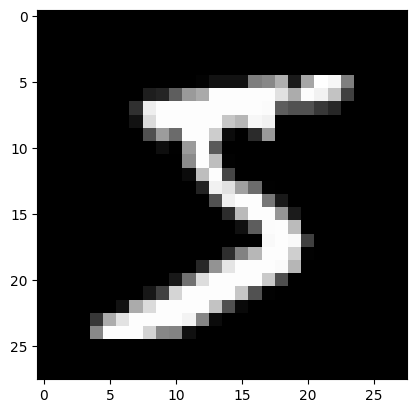

In [35]:
for batch in train_dataset:
    plt.imshow(batch[0], cmap='gray')
    break

# Generator model

In [36]:
def build_generator(noise_dim):
    model = Sequential()

    model.add(Dense(64 * 7 * 7, activation="relu", input_dim=noise_dim))
    model.add(Reshape((7, 7, 64)))
    model.add(Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"))
    model.add(Activation("sigmoid"))
    model.add(Conv2DTranspose(16, kernel_size=4, strides=2, padding="same"))
    model.add(Activation("sigmoid"))
    model.add(Conv2D(1, kernel_size=4, padding="same"))
    model.add(Activation("tanh")) # Dont change

    return model

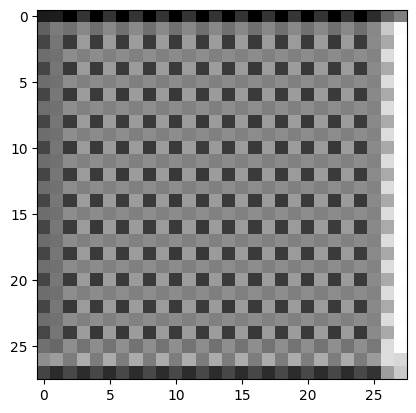

In [37]:
generator = build_generator(20)

noise = tf.random.normal([1, 20])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0], cmap='gray')

In [38]:
generated_image.shape

TensorShape([1, 28, 28, 1])

# Discriminator model

In [39]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=image_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [40]:
discriminator = build_discriminator((28,28,1))
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.5038906]], shape=(1, 1), dtype=float32)


# Loss functions and optimizers

In [41]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [42]:
# We create the labels in the loss function.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [43]:
def generator_loss(fake_output):
    # We want the dicriminator to think all fake images are correct.
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [44]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Train the models

In [45]:
@tf.function
def train_step(images, noise_dim):
    noise = tf.random.normal([64, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Set batchsize and number of generated exampels to the same number
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [46]:
def show_generated_image(generator, noise_dim):
    # Generate random noise as input
    noise = np.random.normal(0, 1, (1, noise_dim))

    # Generate an image from the noise
    generated_image = generator.predict(noise)[0]

    # Plot the generated image
    plt.imshow(generated_image, cmap='gray')
    plt.axis('off')
    plt.show()

In [47]:
def train(dataset, epochs, noise_dim):
    for epoch in range(epochs):
        start = time.time()
    
        for image_batch in dataset:
            train_step(image_batch, noise_dim)
        
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
        # Show generated image
        show_generated_image(generator, noise_dim)


Time for epoch 1 is 21.169548511505127 sec
1/1 [==============================] - 0s 98ms/step


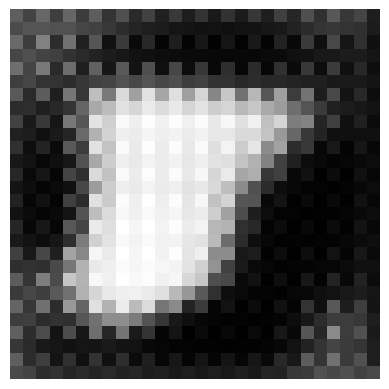

Time for epoch 2 is 19.898653984069824 sec
1/1 [==============================] - 0s 15ms/step


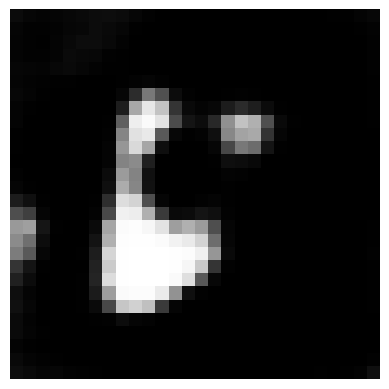

Time for epoch 3 is 20.13651418685913 sec
1/1 [==============================] - 0s 14ms/step


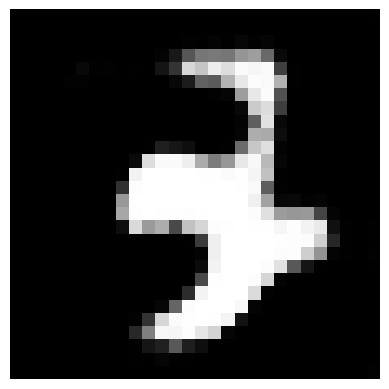

Time for epoch 4 is 20.355705976486206 sec
1/1 [==============================] - 0s 22ms/step


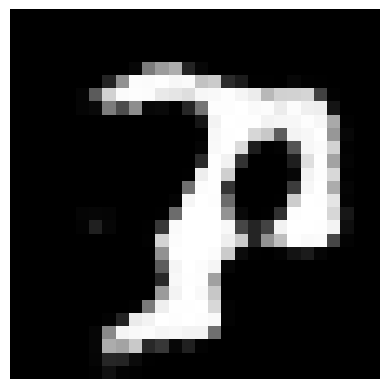

Time for epoch 5 is 19.720532178878784 sec
1/1 [==============================] - 0s 15ms/step


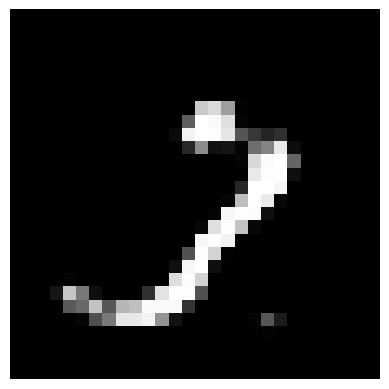

In [49]:
train(train_dataset, 5, 20)

c:\Users\Agam\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time for epoch 1 is 28.647368669509888 sec
1/1 [==============================] - 0s 105ms/step


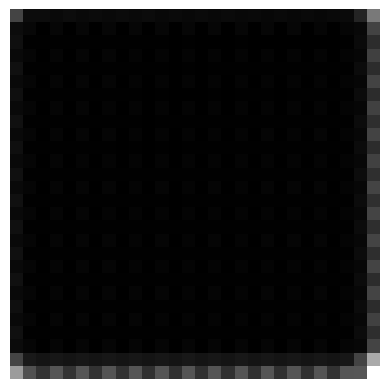

Time for epoch 2 is 22.192845582962036 sec
1/1 [==============================] - 0s 17ms/step


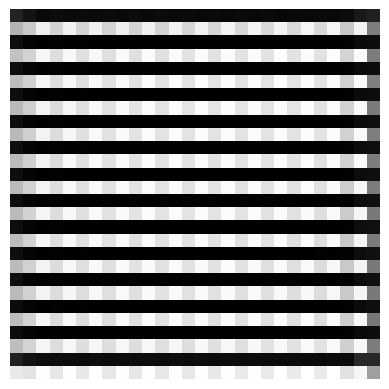

Time for epoch 3 is 21.87791633605957 sec
1/1 [==============================] - 0s 15ms/step


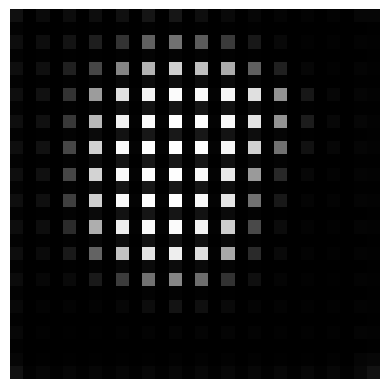

Time for epoch 4 is 24.339877367019653 sec
1/1 [==============================] - 0s 20ms/step


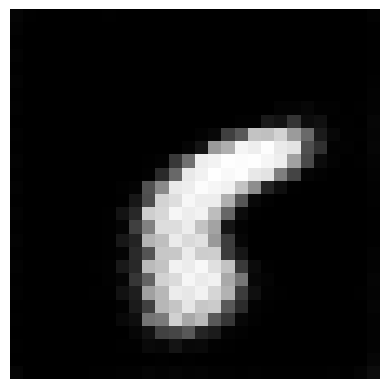

Time for epoch 5 is 24.218759059906006 sec
1/1 [==============================] - 0s 17ms/step


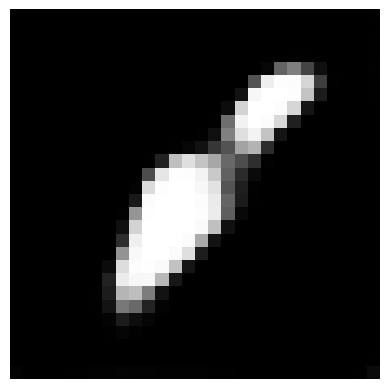

Time for epoch 6 is 22.60459566116333 sec
1/1 [==============================] - 0s 17ms/step


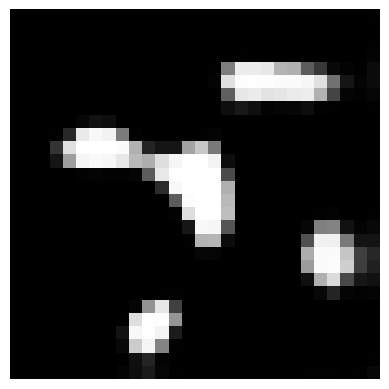

Time for epoch 7 is 25.959723234176636 sec
1/1 [==============================] - 0s 16ms/step


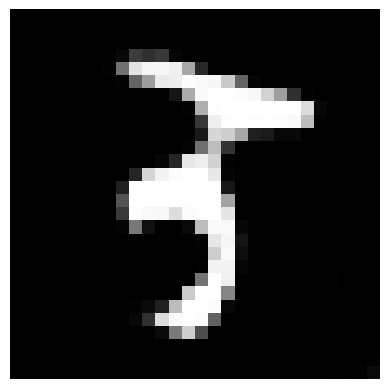

Time for epoch 8 is 25.590903282165527 sec
1/1 [==============================] - 0s 16ms/step


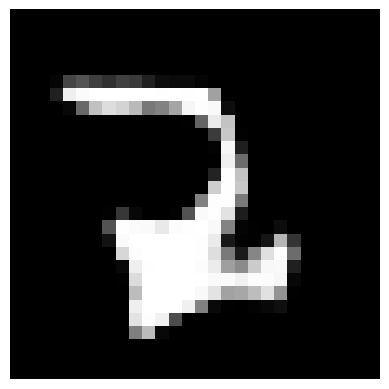

Time for epoch 9 is 26.74730348587036 sec
1/1 [==============================] - 0s 15ms/step


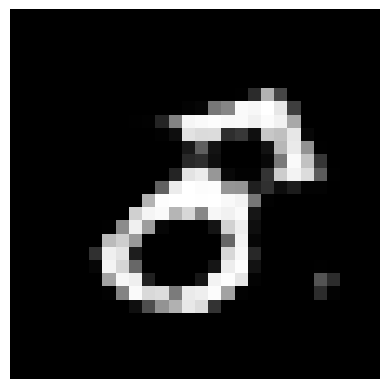

Time for epoch 10 is 26.68451499938965 sec
1/1 [==============================] - 0s 16ms/step


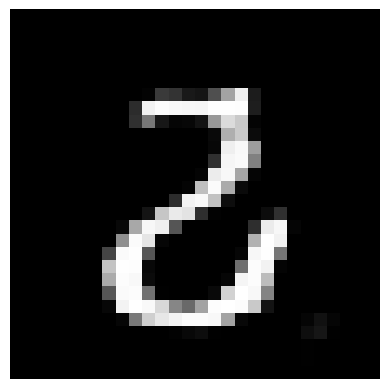

Time for epoch 11 is 23.87090277671814 sec
1/1 [==============================] - 0s 18ms/step


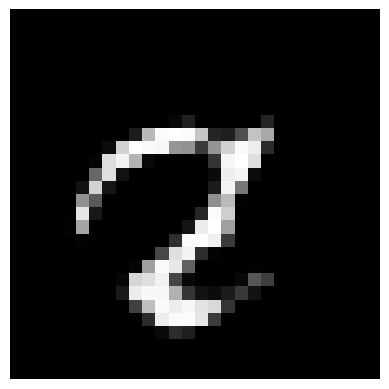

Time for epoch 12 is 23.619640827178955 sec
1/1 [==============================] - 0s 28ms/step


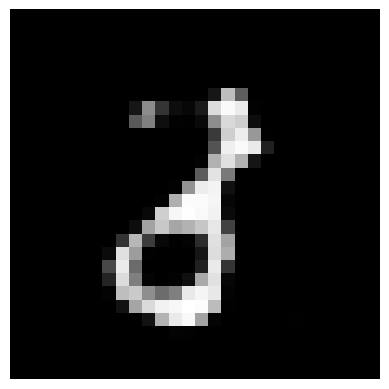

Time for epoch 13 is 23.50755739212036 sec
1/1 [==============================] - 0s 18ms/step


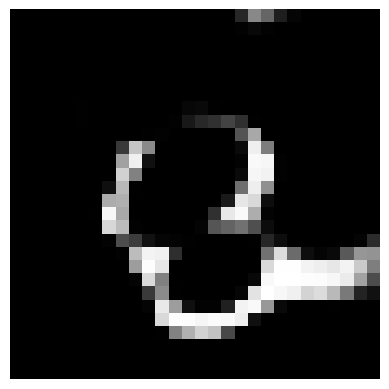

Time for epoch 14 is 21.61099362373352 sec
1/1 [==============================] - 0s 19ms/step


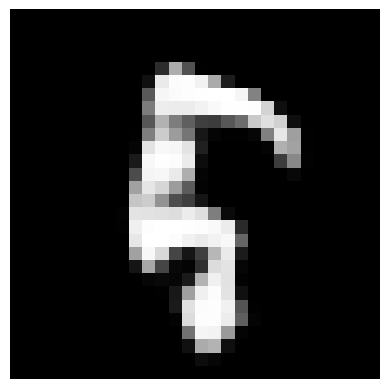

Time for epoch 15 is 25.419575452804565 sec
1/1 [==============================] - 0s 16ms/step


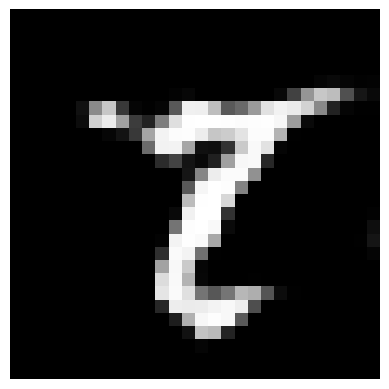

Time for epoch 16 is 24.833829879760742 sec
1/1 [==============================] - 0s 16ms/step


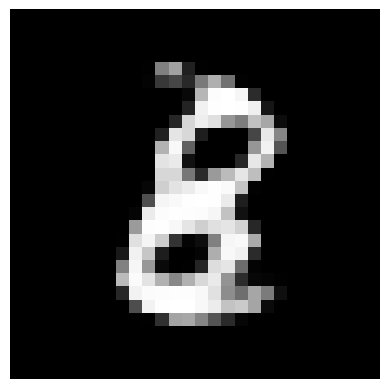

Time for epoch 17 is 27.365245580673218 sec
1/1 [==============================] - 0s 14ms/step


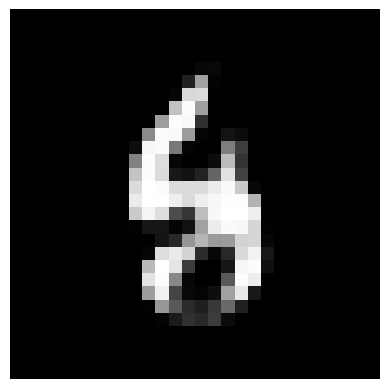

Time for epoch 18 is 23.628143787384033 sec
1/1 [==============================] - 0s 18ms/step


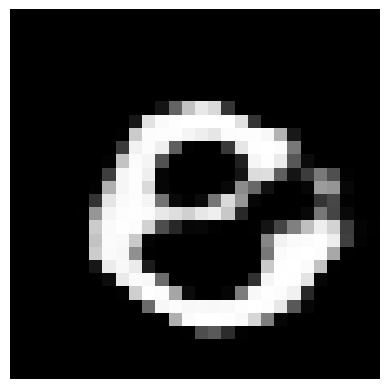

Time for epoch 19 is 21.58977508544922 sec
1/1 [==============================] - 0s 17ms/step


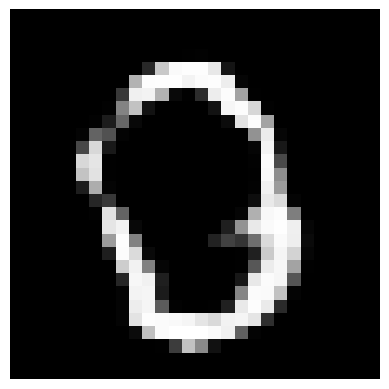

Time for epoch 20 is 20.78889751434326 sec
1/1 [==============================] - 0s 16ms/step


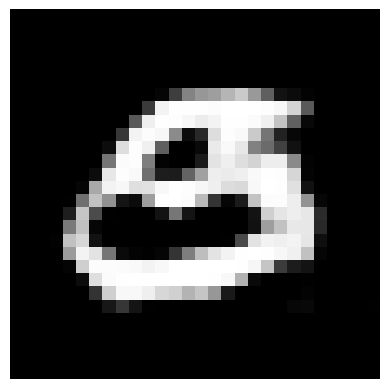

Time for epoch 21 is 20.761389017105103 sec
1/1 [==============================] - 0s 15ms/step


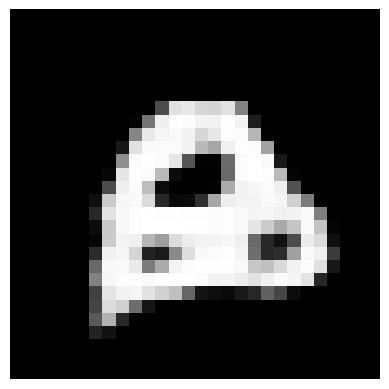

Time for epoch 22 is 20.942312717437744 sec
1/1 [==============================] - 0s 16ms/step


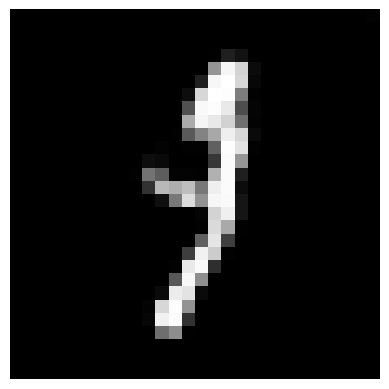

Time for epoch 23 is 20.784806728363037 sec
1/1 [==============================] - 0s 15ms/step


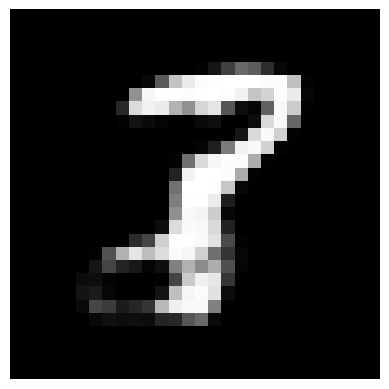

Time for epoch 24 is 20.418498039245605 sec
1/1 [==============================] - 0s 17ms/step


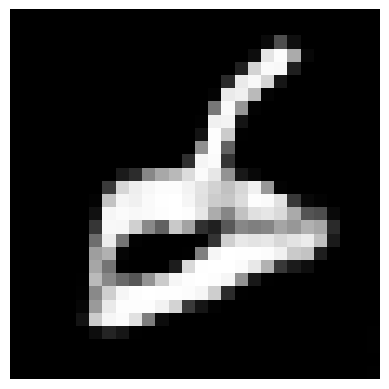

Time for epoch 25 is 20.330212593078613 sec
1/1 [==============================] - 0s 17ms/step


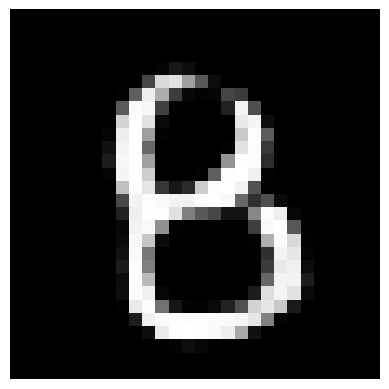

Time for epoch 26 is 20.345396518707275 sec
1/1 [==============================] - 0s 18ms/step


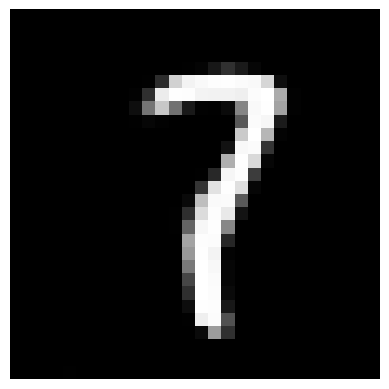

Time for epoch 27 is 20.18620228767395 sec
1/1 [==============================] - 0s 16ms/step


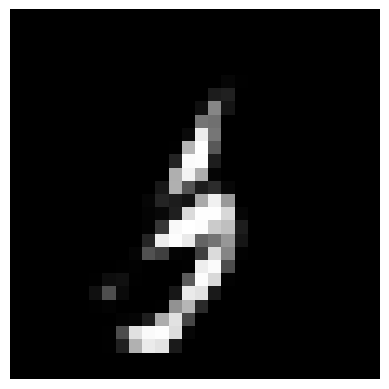

Time for epoch 28 is 20.151227474212646 sec
1/1 [==============================] - 0s 16ms/step


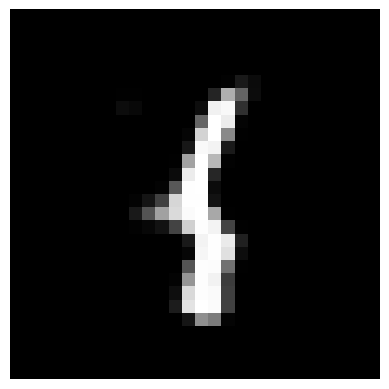

Time for epoch 29 is 20.29997992515564 sec
1/1 [==============================] - 0s 20ms/step


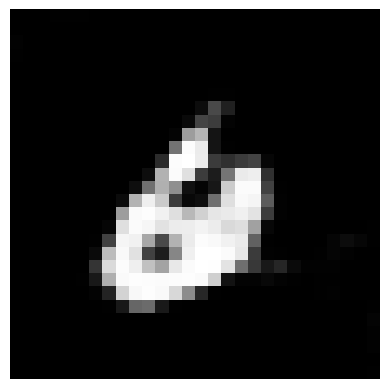

Time for epoch 30 is 20.141153573989868 sec
1/1 [==============================] - 0s 17ms/step


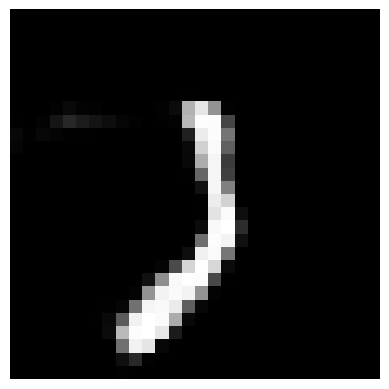

Time for epoch 31 is 20.2219135761261 sec
1/1 [==============================] - 0s 16ms/step


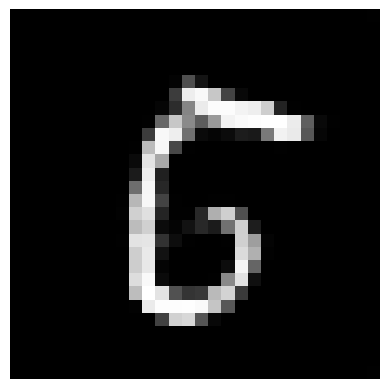

Time for epoch 32 is 20.300397157669067 sec
1/1 [==============================] - 0s 16ms/step


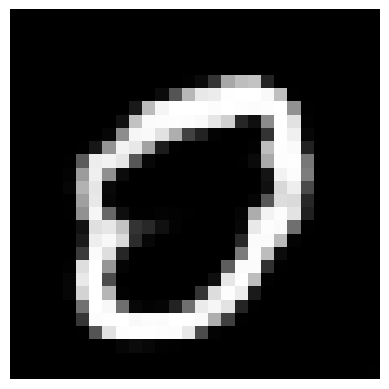

Time for epoch 33 is 20.19760775566101 sec
1/1 [==============================] - 0s 17ms/step


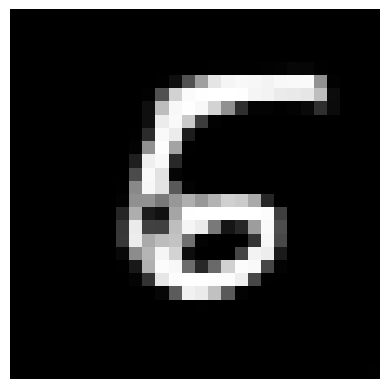

Time for epoch 34 is 20.273820877075195 sec
1/1 [==============================] - 0s 17ms/step


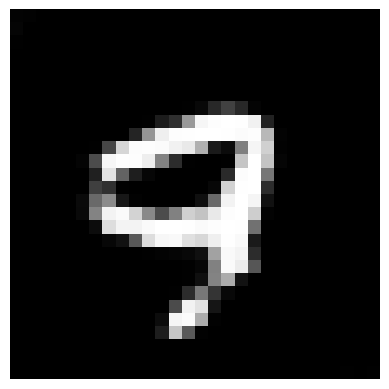

Time for epoch 35 is 20.072834491729736 sec
1/1 [==============================] - 0s 15ms/step


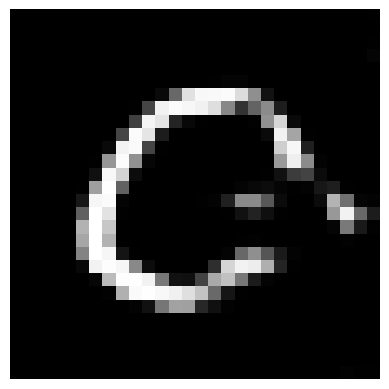

Time for epoch 36 is 20.289633750915527 sec
1/1 [==============================] - 0s 16ms/step


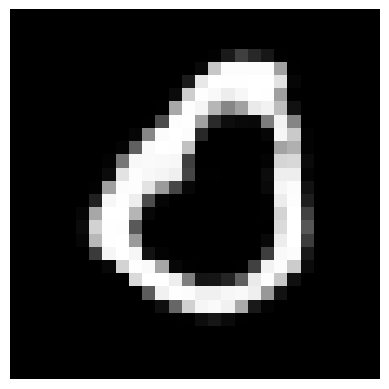

Time for epoch 37 is 19.65619659423828 sec
1/1 [==============================] - 0s 18ms/step


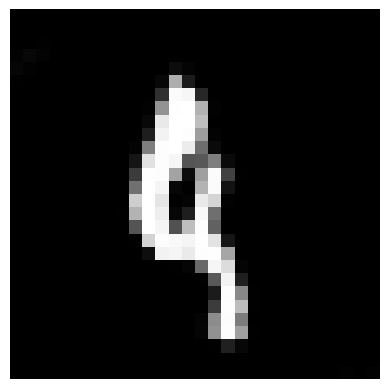

Time for epoch 38 is 20.62645125389099 sec
1/1 [==============================] - 0s 22ms/step


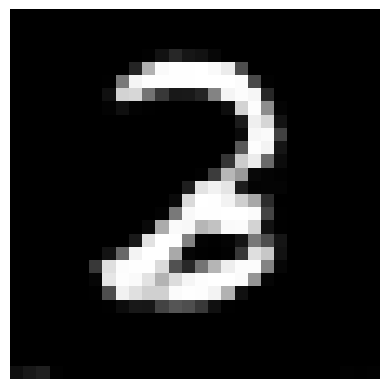

Time for epoch 39 is 21.068917751312256 sec
1/1 [==============================] - 0s 17ms/step


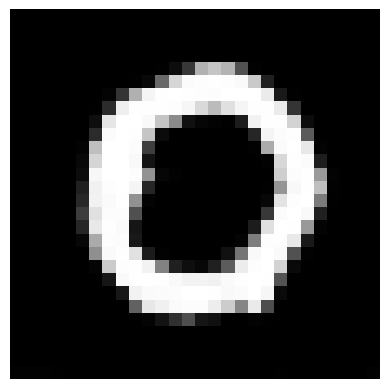

Time for epoch 40 is 21.1727237701416 sec
1/1 [==============================] - 0s 19ms/step


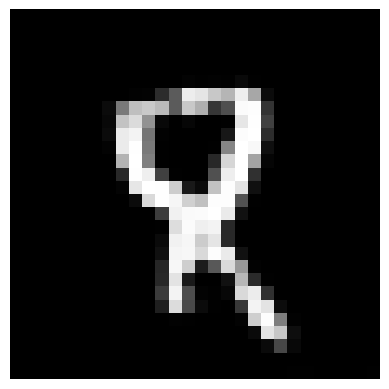

Time for epoch 41 is 19.899271726608276 sec
1/1 [==============================] - 0s 17ms/step


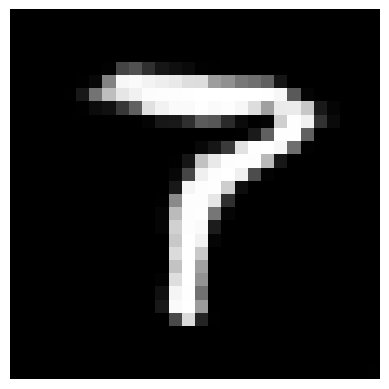

Time for epoch 42 is 20.270607709884644 sec
1/1 [==============================] - 0s 17ms/step


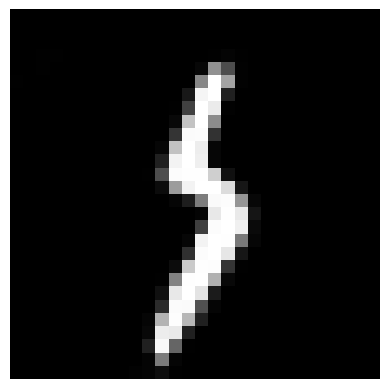

Time for epoch 43 is 19.742812871932983 sec
1/1 [==============================] - 0s 21ms/step


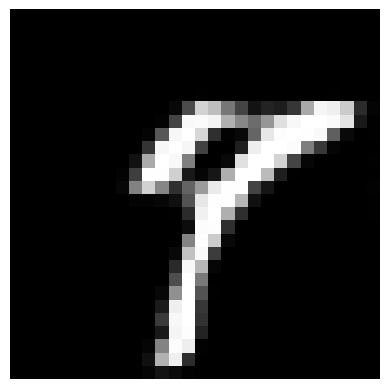

Time for epoch 44 is 20.186359643936157 sec
1/1 [==============================] - 0s 27ms/step


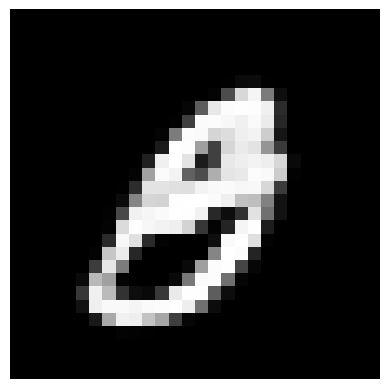

Time for epoch 45 is 20.46613335609436 sec
1/1 [==============================] - 0s 23ms/step


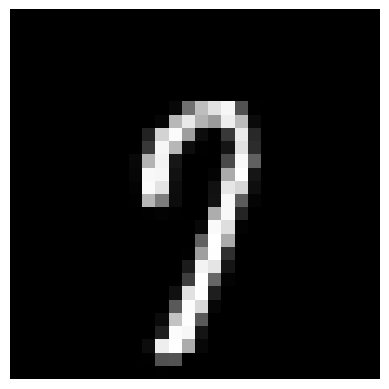

Time for epoch 46 is 20.36414074897766 sec
1/1 [==============================] - 0s 15ms/step


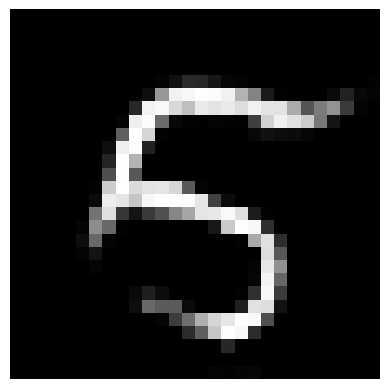

Time for epoch 47 is 19.930366277694702 sec
1/1 [==============================] - 0s 16ms/step


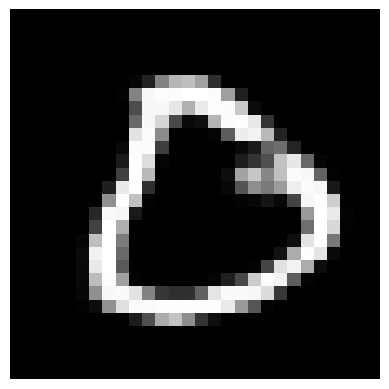

Time for epoch 48 is 20.185492753982544 sec
1/1 [==============================] - 0s 15ms/step


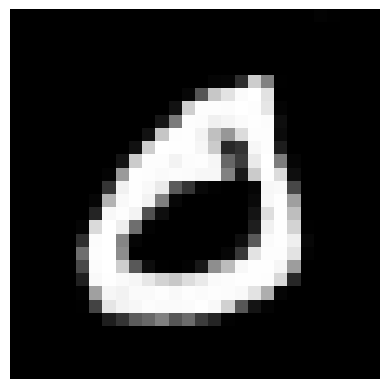

Time for epoch 49 is 20.123428344726562 sec
1/1 [==============================] - 0s 16ms/step


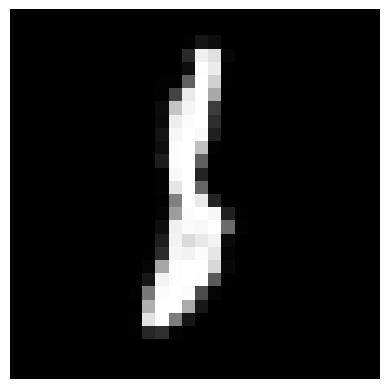

Time for epoch 50 is 20.355247735977173 sec
1/1 [==============================] - 0s 16ms/step


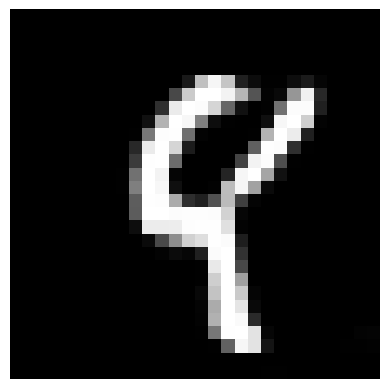

In [24]:
train(train_dataset, 50, 20)

# Tasks
Change the model architectures and try to generate as good images as possible.

Remember to not only change the generator. If the discriminator gets better, the generator need to generate better images.